# **Background**

Medical Image Segmentation is the process of automatic detection of boundaries within images. In this exercise, we train a convolutional neural network with [U-Net](https://arxiv.org/abs/1505.04597) architecture, which training strategy relies on the strong use of data augmentation to improve the efficiency of available annotated samples.

Our motivation is to automatically identify lung opacities in chest x-rays for the [RSNA Pneumonia Detection Challenge](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/leaderboard).

The model training is done with two chest x-rays datasets:
- [Montgomery County and Shenzhen Hospital](https://www.kaggle.com/datasets/kmader/pulmonary-chest-xray-abnormalities).
- The Montgomery County dataset includes manually segmented lung masks while Shenzhen Hospital dataset was manually segmented by [Stirenko et al](https://arxiv.org/abs/1803.01199).
- The lung segmentation masks were dilated to load lung boundary information within the training net and the images were resized to 512x512 pixels.




# **Data preparation**



## 1. Prepare the input segmentation directory structure.

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K  # Alias it to 'K'
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

from glob import glob
from tqdm import tqdm

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Deep Learning/datasets"


Mounted at /content/drive


In [3]:
# Define the segmentation directory inside your base path
os.makedirs(f"{path}/segmentation", exist_ok=True)
segmentation_path = os.path.join(path, "segmentation")

# Create the required directories
os.makedirs(f"{segmentation_path}/test", exist_ok=True)
os.makedirs(f"{segmentation_path}/train", exist_ok=True)
os.makedirs(f"{segmentation_path}/train/augmentation", exist_ok=True)
os.makedirs(f"{segmentation_path}/train/image", exist_ok=True)
os.makedirs(f"{segmentation_path}/train/mask", exist_ok=True)
os.makedirs(f"{segmentation_path}/train/dilate", exist_ok=True)

# The merged dir for datasets
INPUT_DIR = os.path.join(path)
SEGMENTATION_DIR = os.path.join(INPUT_DIR, "segmentation")
SEGMENTATION_TEST_DIR = os.path.join(SEGMENTATION_DIR, "test")

SEGMENTATION_TRAIN_DIR = os.path.join(SEGMENTATION_DIR, "train")
SEGMENTATION_AUG_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "augmentation")
SEGMENTATION_IMAGE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "image")
SEGMENTATION_MASK_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "mask")
SEGMENTATION_DILATE_DIR = os.path.join(SEGMENTATION_TRAIN_DIR, "dilate")

print(SEGMENTATION_AUG_DIR)

/content/drive/MyDrive/Deep Learning/datasets/segmentation/train/augmentation


In [4]:
# Define appropriate constants for directory paths and training parameters
SEGMENTATION_SOURCE_DIR = INPUT_DIR

SHENZHEN_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, "ChinaSet_AllFiles")
SHENZHEN_IMAGE_DIR = os.path.join(SHENZHEN_TRAIN_DIR, "CXR_png")
SHENZHEN_MASK_DIR = os.path.join(SHENZHEN_TRAIN_DIR, "mask")

MONTGOMERY_TRAIN_DIR = os.path.join(SEGMENTATION_SOURCE_DIR, "MontgomerySet")
MONTGOMERY_IMAGE_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, "CXR_png")
MONTGOMERY_LEFT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, \
                                        "ManualMask", "leftMask")
MONTGOMERY_RIGHT_MASK_DIR = os.path.join(MONTGOMERY_TRAIN_DIR, \
                                         "ManualMask", "rightMask")

print(MONTGOMERY_RIGHT_MASK_DIR)

/content/drive/MyDrive/Deep Learning/datasets/MontgomerySet/ManualMask/rightMask


## 2. Preprocess data

### Process the Montgomery dataset
1. Combine left and right lung segmentation masks of Montgomery chest x-rays
1. Resize images to 512x512 pixels
1. Dilate masks to gain more information on the edge of lungs
1. Split images into training and test datasets
1. Write images to /segmentation directory



In [5]:
DILATE_KERNEL = np.ones((15, 15), np.uint8)

# List all mask on left lung
montgomery_left_mask_dir = glob(os.path.join(MONTGOMERY_LEFT_MASK_DIR, '*.png'))

# Select 50 image for traning
montgomery_train= montgomery_left_mask_dir[50:]

for left_image_file in tqdm(montgomery_train):
    left_mask = cv2.imread(left_image_file, cv2.IMREAD_GRAYSCALE)
    left_mask = cv2.resize(left_mask, (512, 512))

    base_file = os.path.basename(left_image_file) #image file name
    image_file = os.path.join(MONTGOMERY_IMAGE_DIR, base_file)
    image = cv2.imread(image_file)
    image = cv2.resize(image, (512, 512))

    right_image_file = os.path.join(MONTGOMERY_RIGHT_MASK_DIR, base_file)
    right_mask = cv2.imread(right_image_file, cv2.IMREAD_GRAYSCALE)
    right_mask = cv2.resize(right_mask, (512, 512))

    mask = np.maximum(left_mask, right_mask)
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), \
                    image)
    cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), \
                    mask)
    cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), \
                    mask_dilate)

100%|██████████| 88/88 [02:44<00:00,  1.86s/it]


In [6]:
# Select 50 image for testing
montgomery_test = montgomery_left_mask_dir[0:50]

for left_image_file in tqdm(montgomery_test):
    left_mask = cv2.imread(left_image_file, cv2.IMREAD_GRAYSCALE)
    left_mask = cv2.resize(left_mask, (512, 512))

    base_file = os.path.basename(left_image_file) #image file name
    image_file = os.path.join(MONTGOMERY_IMAGE_DIR, base_file)
    image = cv2.imread(image_file)
    image = cv2.resize(image, (512, 512))

    right_image_file = os.path.join(MONTGOMERY_RIGHT_MASK_DIR, base_file)
    right_mask = cv2.imread(right_image_file, cv2.IMREAD_GRAYSCALE)
    right_mask = cv2.resize(right_mask, (512, 512))

    mask = np.maximum(left_mask, right_mask)
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)

    filename, fileext = os.path.splitext(base_file)
    cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), \
                    image)
    cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_mask%s" % (filename, fileext)), mask)
    cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 50/50 [01:32<00:00,  1.86s/it]


### Process the Shenzhen dataset
1. Resize Shenzhen Hospital chest x-ray images to 512x512 pixels
1. Dilate masks to gain more information on the edge of lungs
1. Split images into training and test datasets
1. Write images to /segmentation directory

In [7]:
# List all mask on lungs-> choose image with mask as some image missing mask
image_files = set(os.listdir(SHENZHEN_IMAGE_DIR))
mask_files = set(os.listdir(SHENZHEN_MASK_DIR))
img_files_cleaned = {filename.replace(".png", "_mask.png") for filename in image_files}
common_files = list(img_files_cleaned.intersection(mask_files))
shenzhen_mask_dir = [os.path.join(SHENZHEN_MASK_DIR, img) for img in common_files]

# 50 images for train
shenzhen_train= shenzhen_mask_dir[50:]
for mask_file in tqdm(shenzhen_train):

    base_file = os.path.basename(mask_file).replace("_mask", "")
    image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)
    image = cv2.imread(image_file)
    image = cv2.resize(image, (512, 512))

    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (512, 512))
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    cv2.imwrite(os.path.join(SEGMENTATION_IMAGE_DIR, base_file), \
                    image)
    cv2.imwrite(os.path.join(SEGMENTATION_MASK_DIR, base_file), \
                    mask)
    cv2.imwrite(os.path.join(SEGMENTATION_DILATE_DIR, base_file), \
                    mask_dilate)

100%|██████████| 117/117 [01:29<00:00,  1.30it/s]


In [8]:
# 50 image for test
shenzhen_test = shenzhen_mask_dir[0:50]
for mask_file in tqdm(shenzhen_test):

    base_file = os.path.basename(mask_file).replace("_mask", "")
    image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)
    image = cv2.imread(image_file)
    image = cv2.resize(image, (512, 512))

    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (512, 512))
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)

    filename, fileext = os.path.splitext(base_file)

    cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, base_file), \
                    image)
    cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_mask%s" % (filename, fileext)), mask)
    cv2.imwrite(os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


### Functions to display segmentation as overlays

In [9]:
def add_colored_dilate(image, mask_image, dilate_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    dilate_image_gray = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    dilate = cv2.bitwise_and(dilate_image, dilate_image, mask=dilate_image_gray)

    mask_coord = np.where(mask!=[0,0,0])
    dilate_coord = np.where(dilate!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]

    ret = cv2.addWeighted(image, 0.7, dilate, 0.3, 0)
    ret = cv2.addWeighted(ret, 0.7, mask, 0.3, 0)

    return ret

def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

Show some Montgomery chest x-rays and its lung segmentation masks from training and test dataset to verify the procedure above. In merged image it is possible to see the difference between the dilated mask in blue and the original mask in red.

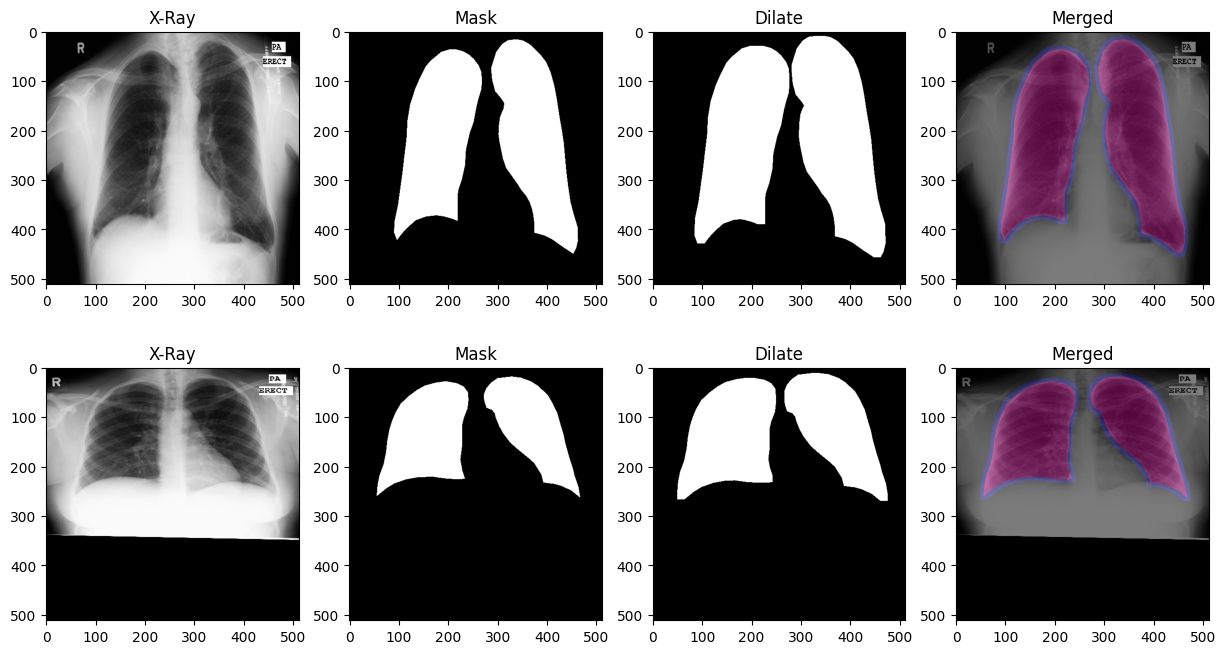

In [10]:
base_file = os.path.basename(montgomery_train[1])

image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(montgomery_test[1])
filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

Show some Shenzhen Hospital chest x-rays and its lung segmentation masks from training and test dataset to verify the procedure above. In merged image it is possible to see the difference between the dilated mask in blue and the original mask in red.

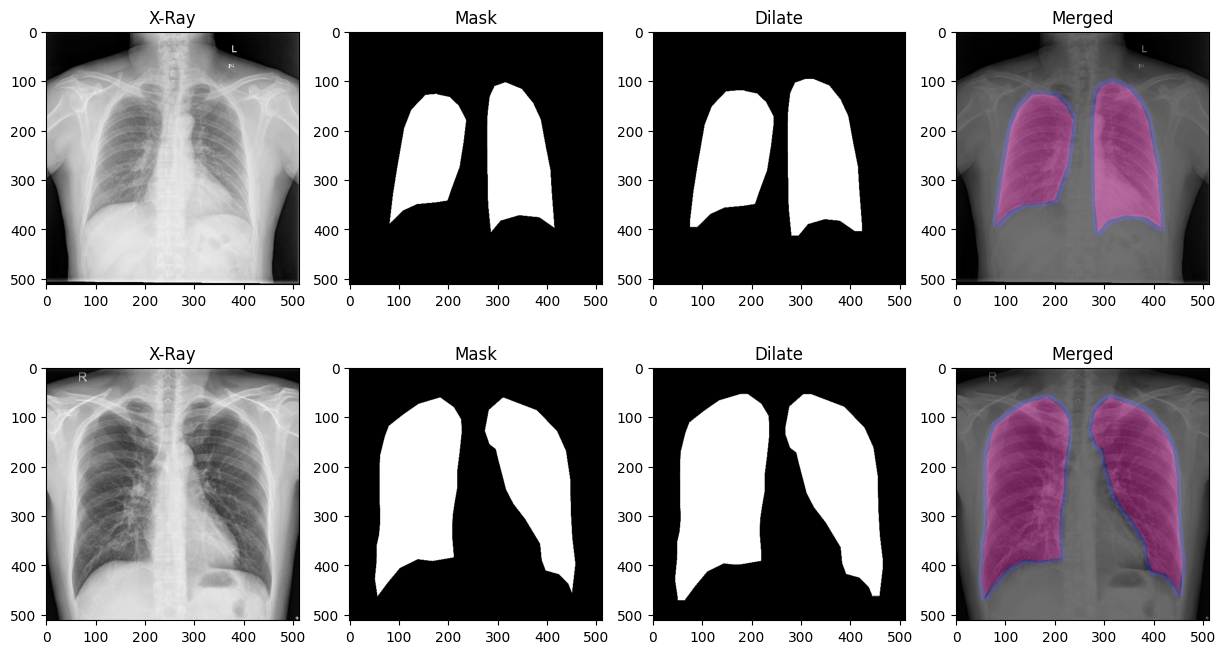

In [11]:
base_file = os.path.basename(shenzhen_train[2].replace("_mask", ""))
image_file = os.path.join(SEGMENTATION_IMAGE_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_MASK_DIR, base_file)
dilate_image_file = os.path.join(SEGMENTATION_DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(shenzhen_test[0].replace("_mask", ""))
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
filename, fileext = os.path.splitext(base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))

filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(SEGMENTATION_TEST_DIR, base_file)
mask_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                               "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(SEGMENTATION_TEST_DIR, \
                                 "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)

Print the count of images and segmentation lung masks available to test and train the model

In [12]:
train_files = glob(os.path.join(SEGMENTATION_IMAGE_DIR, "*.png"))
test_files = glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png"))
mask_files = glob(os.path.join(SEGMENTATION_MASK_DIR, "*.png"))
dilate_files = glob(os.path.join(SEGMENTATION_DILATE_DIR, "*.png"))

(len(train_files),
 len(test_files), \
 len(mask_files), \
 len(dilate_files))

(205, 300, 205, 205)

# **Segmentation with DeepLabv3+**


## 1. Data augmentation helper function for training the net

### Load train data

In [13]:
def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_datagen = ImageDataGenerator(**aug_dict)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

### Load test chest x-ray images

In [14]:
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        img = test_load_image(test_file, target_size)  # Load image
        yield (img,)

def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))
        print(f"Saving prediction: {result_file}")
        cv2.imwrite(result_file, img)

def add_suffix(base_file, suffix):
    filename, fileext = os.path.splitext(base_file)
    return "%s_%s%s" % (filename, suffix, fileext)


In [15]:
test_files = [test_file for test_file in glob(os.path.join(SEGMENTATION_TEST_DIR, "*.png")) \
              if ("_mask" not in test_file \
                  and "_dilate" not in test_file \
                  and "_predict" not in test_file)]

validation_data = (test_load_image(test_files[0], target_size=(512, 512)),
                    test_load_image(add_suffix(test_files[0], "dilate"), target_size=(512, 512)))

len(test_files), len(validation_data)

(100, 2)

## 2. DeepLabv3 architecture

In [16]:
import os
import math
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K  # Correct backend import for dice functions
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D, Conv2DTranspose, Concatenate, AveragePooling2D
from tensorflow.keras.applications import ResNet101

# Define Dice Coefficient and Loss
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])  # Fix: Flatten tensor
    y_pred_f = tf.reshape(y_pred, [-1])  # Fix: Flatten tensor
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D, Conv2DTranspose, Concatenate, AveragePooling2D
from tensorflow.keras.applications import ResNet101

def ASPP(x, atrous_rates):
    # Define the atrous convolutional layers
    conv_1x1 = Conv2D(256, (1, 1), padding='same')(x)
    conv_3x3_1 = Conv2D(256, (3, 3), dilation_rate=atrous_rates[0], padding='same')(x)
    conv_3x3_2 = Conv2D(256, (3, 3), dilation_rate=atrous_rates[1], padding='same')(x)
    conv_3x3_3 = Conv2D(256, (3, 3), dilation_rate=atrous_rates[2], padding='same')(x)

    # Image pooling branch
    img_pool = AveragePooling2D(pool_size=(x.shape[1], x.shape[2]))(x)
    img_pool = Conv2D(256, (1, 1), padding='same')(img_pool)
    img_pool = UpSampling2D(size=(x.shape[1], x.shape[2]), interpolation='bilinear')(img_pool)

    # Concatenate the outputs
    x = Concatenate()([conv_1x1, conv_3x3_1, conv_3x3_2, conv_3x3_3, img_pool])

    return x

atrous_rates = [6, 12, 18]

def unet(input_shape):
    # Load pre-trained ResNet50 as the encoder
    base_model = ResNet101(weights=None, include_top=False, input_shape=input_shape)

    # Modify the first layer to accept single-channel input
    base_model.layers[0].trainable = True  # Make the first layer trainable
    base_model.layers[0] = Conv2D(64, (7, 7), strides=(2, 2), padding='same', input_shape=input_shape)(base_model.input)

    # Freeze the rest of the base model layers
    for layer in base_model.layers[1:]:
        layer.trainable = False

    # Get the output of the last convolutional layer
    x = base_model.output

    # Apply ASPP
    x = ASPP(x, atrous_rates)

    # Decoder
    x = Conv2D(256, (1, 1), padding='same')(x)
    # Apply multiple upsampling steps to reach the original resolution
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    # Final convolutional layer for segmentation
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    return Model(inputs=base_model.input, outputs=outputs)

# Example usage
input_shape = (512, 512, 1)  # Adjust based on your dataset
model = unet(input_shape)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 518, 518, 1)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 256, 256, 64)   │          3,200 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 256, 256, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 256, 256, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 258, 258, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 128, 128, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 128, 128, 64)   │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 128, 128, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 128, 128, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 128, 128, 64)   │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 128, 128, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 128, 128, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 128, 128, 256)  │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 128, 128, 256)  │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 58,554,369 (223.37 MB)

 Trainable params: 15,902,465 (60.66 MB)

 Non-trainable params: 42,651,904 (162.70 MB)

Prepare the U-Net model and train the model. It will take a while...

## 3. Train the DeepLabv3 model

In [17]:
# Set Parameters
BATCH_SIZE = 4
EPOCHS = 50  # Production Mode
# EPOCHS = 16  # Development Mode (Uncomment for testing)

# Data Augmentation Parameters
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

# Train Data Generator
train_gen = train_generator(BATCH_SIZE,
                            SEGMENTATION_TRAIN_DIR,
                            'image',
                            'dilate',
                            train_generator_args,
                            target_size=(512, 512),
                            save_to_dir=os.path.abspath(SEGMENTATION_AUG_DIR))


# Automatically run on GPU if available
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"

with tf.device(device):  # Run model on GPU
# Initialize and Compile Model
  model = unet((512, 512, 1))  # Fix: Pass input size properly
  model.compile(optimizer=Adam(learning_rate=1e-5),
                loss=dice_coef_loss,
                metrics=[dice_coef, 'binary_accuracy'])

  # Model Checkpoint Callback
  checkpoint_filepath = "unet_lung_seg.h5"
  model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                    monitor='loss',
                                    verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False)

  # Ensure `train_files` and `validation_data` exist
  if 'train_files' not in globals():
      raise ValueError("train_files is not defined. Ensure it is a list of training images.")

  if 'validation_data' not in globals():
      raise ValueError("validation_data is not defined. Provide a valid validation generator or dataset.")

  # Train Model
  history = model.fit(train_gen,
                      steps_per_epoch=math.ceil(len(train_files) / BATCH_SIZE),  # Ensure integer steps
                      epochs=EPOCHS,
                      callbacks=[model_checkpoint],
                      validation_data=validation_data)


Found 205 images belonging to 1 classes.
Found 205 images belonging to 1 classes.
Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - binary_accuracy: 0.3040 - dice_coef: 0.4193 - loss: -0.4193
Epoch 1: loss improved from inf to -0.45117, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 64s 735ms/step - binary_accuracy: 0.3042 - dice_coef: 0.4200 - loss: -0.4199 - val_binary_accuracy: 0.3908 - val_dice_coef: 0.4935 - val_loss: -0.4935
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - binary_accuracy: 0.5179 - dice_coef: 0.5247 - loss: -0.5247
Epoch 2: loss improved from -0.45117 to -0.55972, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 448ms/step - binary_accuracy: 0.5200 - dice_coef: 0.5254 - loss: -0.5253 - val_binary_accuracy: 0.8471 - val_dice_coef: 0.6987 - val_loss: -0.6987
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - binary_accuracy: 0.7947 - dice_coef: 0.6467 - loss: -0.6466
Epoch 3: loss improved from -0.55972 to -0.66431, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 433ms/step - binary_accuracy: 0.7949 - dice_coef: 0.6470 - loss: -0.6470 - val_binary_accuracy: 0.8816 - val_dice_coef: 0.7777 - val_loss: -0.7777
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - binary_accuracy: 0.8260 - dice_coef: 0.6974 - loss: -0.6974
Epoch 4: loss improved from -0.66431 to -0.70363, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - binary_accuracy: 0.8261 - dice_coef: 0.6975 - loss: -0.6975 - val_binary_accuracy: 0.8827 - val_dice_coef: 0.7978 - val_loss: -0.7978
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - binary_accuracy: 0.8305 - dice_coef: 0.7171 - loss: -0.7171
Epoch 5: loss improved from -0.70363 to -0.72439, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 442ms/step - binary_accuracy: 0.8306 - dice_coef: 0.7172 - loss: -0.7172 - val_binary_accuracy: 0.8868 - val_dice_coef: 0.8116 - val_loss: -0.8116
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - binary_accuracy: 0.8378 - dice_coef: 0.7342 - loss: -0.7342
Epoch 6: loss improved from -0.72439 to -0.73907, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - binary_accuracy: 0.8379 - dice_coef: 0.7343 - loss: -0.7343 - val_binary_accuracy: 0.9094 - val_dice_coef: 0.8388 - val_loss: -0.8388
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - binary_accuracy: 0.8517 - dice_coef: 0.7467 - loss: -0.7467
Epoch 7: loss improved from -0.73907 to -0.75139, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 442ms/step - binary_accuracy: 0.8517 - dice_coef: 0.7468 - loss: -0.7468 - val_binary_accuracy: 0.9166 - val_dice_coef: 0.8481 - val_loss: -0.8481
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - binary_accuracy: 0.8643 - dice_coef: 0.7644 - loss: -0.7644
Epoch 8: loss improved from -0.75139 to -0.76375, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 433ms/step - binary_accuracy: 0.8642 - dice_coef: 0.7644 - loss: -0.7644 - val_binary_accuracy: 0.9110 - val_dice_coef: 0.8481 - val_loss: -0.8481
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - binary_accuracy: 0.8628 - dice_coef: 0.7686 - loss: -0.7685
Epoch 9: loss improved from -0.76375 to -0.76919, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 440ms/step - binary_accuracy: 0.8628 - dice_coef: 0.7686 - loss: -0.7686 - val_binary_accuracy: 0.9210 - val_dice_coef: 0.8526 - val_loss: -0.8526
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - binary_accuracy: 0.8733 - dice_coef: 0.7782 - loss: -0.7781
Epoch 10: loss improved from -0.76919 to -0.78157, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - binary_accuracy: 0.8733 - dice_coef: 0.7782 - loss: -0.7782 - val_binary_accuracy: 0.9097 - val_dice_coef: 0.8473 - val_loss: -0.8473
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - binary_accuracy: 0.8724 - dice_coef: 0.7818 - loss: -0.7818
Epoch 11: loss improved from -0.78157 to -0.78446, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 437ms/step - binary_accuracy: 0.8725 - dice_coef: 0.7819 - loss: -0.7819 - val_binary_accuracy: 0.9133 - val_dice_coef: 0.8394 - val_loss: -0.8394
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - binary_accuracy: 0.8823 - dice_coef: 0.7936 - loss: -0.7936
Epoch 12: loss improved from -0.78446 to -0.78973, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 435ms/step - binary_accuracy: 0.8822 - dice_coef: 0.7935 - loss: -0.7935 - val_binary_accuracy: 0.9151 - val_dice_coef: 0.8501 - val_loss: -0.8501
Epoch 13/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - binary_accuracy: 0.8741 - dice_coef: 0.7851 - loss: -0.7851
Epoch 13: loss improved from -0.78973 to -0.79019, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 446ms/step - binary_accuracy: 0.8742 - dice_coef: 0.7852 - loss: -0.7852 - val_binary_accuracy: 0.9164 - val_dice_coef: 0.8459 - val_loss: -0.8459
Epoch 14/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - binary_accuracy: 0.8833 - dice_coef: 0.7953 - loss: -0.7953
Epoch 14: loss improved from -0.79019 to -0.79391, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 441ms/step - binary_accuracy: 0.8833 - dice_coef: 0.7952 - loss: -0.7953 - val_binary_accuracy: 0.9103 - val_dice_coef: 0.8490 - val_loss: -0.8490
Epoch 15/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - binary_accuracy: 0.8821 - dice_coef: 0.7973 - loss: -0.7973
Epoch 15: loss improved from -0.79391 to -0.80263, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step - binary_accuracy: 0.8822 - dice_coef: 0.7974 - loss: -0.7974 - val_binary_accuracy: 0.9127 - val_dice_coef: 0.8377 - val_loss: -0.8377
Epoch 16/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - binary_accuracy: 0.8846 - dice_coef: 0.8038 - loss: -0.8038
Epoch 16: loss did not improve from -0.80263
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 403ms/step - binary_accuracy: 0.8846 - dice_coef: 0.8037 - loss: -0.8037 - val_binary_accuracy: 0.9142 - val_dice_coef: 0.8555 - val_loss: -0.8555
Epoch 17/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - binary_accuracy: 0.8868 - dice_coef: 0.7996 - loss: -0.7996
Epoch 17: loss did not improve from -0.80263
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 420ms/step - binary_accuracy: 0.8868 - dice_coef: 0.7996 - loss: -0.7996 - val_binary_accuracy: 0.9145 - val_dice_coef: 0.8538 - val_loss: -0.8538
Epoch 18/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - binary_accuracy: 0.8828 - dice_coef: 0.8008 - loss: -0.8008
Epoch 18: loss improved from -0

52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - binary_accuracy: 0.8829 - dice_coef: 0.8009 - loss: -0.8008 - val_binary_accuracy: 0.9176 - val_dice_coef: 0.8592 - val_loss: -0.8592
Epoch 19/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - binary_accuracy: 0.8869 - dice_coef: 0.8091 - loss: -0.8091
Epoch 19: loss improved from -0.80443 to -0.80723, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 437ms/step - binary_accuracy: 0.8869 - dice_coef: 0.8090 - loss: -0.8090 - val_binary_accuracy: 0.9174 - val_dice_coef: 0.8561 - val_loss: -0.8561
Epoch 20/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - binary_accuracy: 0.8975 - dice_coef: 0.8186 - loss: -0.8186
Epoch 20: loss improved from -0.80723 to -0.81249, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 440ms/step - binary_accuracy: 0.8975 - dice_coef: 0.8185 - loss: -0.8185 - val_binary_accuracy: 0.9130 - val_dice_coef: 0.8558 - val_loss: -0.8558
Epoch 21/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - binary_accuracy: 0.8860 - dice_coef: 0.8045 - loss: -0.8045
Epoch 21: loss did not improve from -0.81249
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 414ms/step - binary_accuracy: 0.8861 - dice_coef: 0.8047 - loss: -0.8046 - val_binary_accuracy: 0.9168 - val_dice_coef: 0.8613 - val_loss: -0.8613
Epoch 22/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - binary_accuracy: 0.8929 - dice_coef: 0.8178 - loss: -0.8177
Epoch 22: loss improved from -0.81249 to -0.81779, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 447ms/step - binary_accuracy: 0.8930 - dice_coef: 0.8178 - loss: -0.8177 - val_binary_accuracy: 0.9162 - val_dice_coef: 0.8579 - val_loss: -0.8579
Epoch 23/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - binary_accuracy: 0.8964 - dice_coef: 0.8194 - loss: -0.8194
Epoch 23: loss did not improve from -0.81779
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 419ms/step - binary_accuracy: 0.8964 - dice_coef: 0.8194 - loss: -0.8193 - val_binary_accuracy: 0.9169 - val_dice_coef: 0.8614 - val_loss: -0.8614
Epoch 24/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - binary_accuracy: 0.8941 - dice_coef: 0.8162 - loss: -0.8162
Epoch 24: loss improved from -0.81779 to -0.82226, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - binary_accuracy: 0.8942 - dice_coef: 0.8164 - loss: -0.8163 - val_binary_accuracy: 0.9205 - val_dice_coef: 0.8664 - val_loss: -0.8664
Epoch 25/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - binary_accuracy: 0.8996 - dice_coef: 0.8236 - loss: -0.8236
Epoch 25: loss improved from -0.82226 to -0.82291, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 447ms/step - binary_accuracy: 0.8996 - dice_coef: 0.8236 - loss: -0.8236 - val_binary_accuracy: 0.9239 - val_dice_coef: 0.8672 - val_loss: -0.8672
Epoch 26/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - binary_accuracy: 0.8974 - dice_coef: 0.8178 - loss: -0.8178
Epoch 26: loss improved from -0.82291 to -0.82319, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 432ms/step - binary_accuracy: 0.8975 - dice_coef: 0.8180 - loss: -0.8179 - val_binary_accuracy: 0.9195 - val_dice_coef: 0.8662 - val_loss: -0.8662
Epoch 27/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - binary_accuracy: 0.8975 - dice_coef: 0.8240 - loss: -0.8240
Epoch 27: loss improved from -0.82319 to -0.82957, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 453ms/step - binary_accuracy: 0.8976 - dice_coef: 0.8241 - loss: -0.8241 - val_binary_accuracy: 0.9258 - val_dice_coef: 0.8729 - val_loss: -0.8729
Epoch 28/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - binary_accuracy: 0.9024 - dice_coef: 0.8305 - loss: -0.8305
Epoch 28: loss did not improve from -0.82957
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 407ms/step - binary_accuracy: 0.9024 - dice_coef: 0.8305 - loss: -0.8305 - val_binary_accuracy: 0.9214 - val_dice_coef: 0.8695 - val_loss: -0.8695
Epoch 29/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - binary_accuracy: 0.9019 - dice_coef: 0.8340 - loss: -0.8340
Epoch 29: loss improved from -0.82957 to -0.83155, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 444ms/step - binary_accuracy: 0.9020 - dice_coef: 0.8339 - loss: -0.8339 - val_binary_accuracy: 0.9258 - val_dice_coef: 0.8732 - val_loss: -0.8732
Epoch 30/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - binary_accuracy: 0.9018 - dice_coef: 0.8284 - loss: -0.8284
Epoch 30: loss did not improve from -0.83155
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 420ms/step - binary_accuracy: 0.9018 - dice_coef: 0.8284 - loss: -0.8284 - val_binary_accuracy: 0.9284 - val_dice_coef: 0.8705 - val_loss: -0.8705
Epoch 31/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - binary_accuracy: 0.9042 - dice_coef: 0.8239 - loss: -0.8239
Epoch 31: loss improved from -0.83155 to -0.83253, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 452ms/step - binary_accuracy: 0.9042 - dice_coef: 0.8240 - loss: -0.8240 - val_binary_accuracy: 0.9235 - val_dice_coef: 0.8715 - val_loss: -0.8715
Epoch 32/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - binary_accuracy: 0.9089 - dice_coef: 0.8410 - loss: -0.8410
Epoch 32: loss improved from -0.83253 to -0.83381, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 430ms/step - binary_accuracy: 0.9088 - dice_coef: 0.8406 - loss: -0.8408 - val_binary_accuracy: 0.9270 - val_dice_coef: 0.8753 - val_loss: -0.8753
Epoch 33/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - binary_accuracy: 0.9068 - dice_coef: 0.8381 - loss: -0.8380
Epoch 33: loss did not improve from -0.83381
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 418ms/step - binary_accuracy: 0.9068 - dice_coef: 0.8380 - loss: -0.8380 - val_binary_accuracy: 0.9239 - val_dice_coef: 0.8667 - val_loss: -0.8667
Epoch 34/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - binary_accuracy: 0.9082 - dice_coef: 0.8389 - loss: -0.8389
Epoch 34: loss improved from -0.83381 to -0.83869, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 443ms/step - binary_accuracy: 0.9082 - dice_coef: 0.8389 - loss: -0.8389 - val_binary_accuracy: 0.9239 - val_dice_coef: 0.8738 - val_loss: -0.8738
Epoch 35/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - binary_accuracy: 0.9077 - dice_coef: 0.8383 - loss: -0.8384
Epoch 35: loss improved from -0.83869 to -0.84072, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 450ms/step - binary_accuracy: 0.9078 - dice_coef: 0.8383 - loss: -0.8384 - val_binary_accuracy: 0.9278 - val_dice_coef: 0.8728 - val_loss: -0.8728
Epoch 36/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - binary_accuracy: 0.9090 - dice_coef: 0.8426 - loss: -0.8426
Epoch 36: loss improved from -0.84072 to -0.84137, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 436ms/step - binary_accuracy: 0.9091 - dice_coef: 0.8426 - loss: -0.8426 - val_binary_accuracy: 0.9343 - val_dice_coef: 0.8826 - val_loss: -0.8826
Epoch 37/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - binary_accuracy: 0.9112 - dice_coef: 0.8391 - loss: -0.8391
Epoch 37: loss did not improve from -0.84137
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 422ms/step - binary_accuracy: 0.9112 - dice_coef: 0.8392 - loss: -0.8392 - val_binary_accuracy: 0.9163 - val_dice_coef: 0.8653 - val_loss: -0.8653
Epoch 38/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - binary_accuracy: 0.9081 - dice_coef: 0.8416 - loss: -0.8416
Epoch 38: loss improved from -0.84137 to -0.84453, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 461ms/step - binary_accuracy: 0.9082 - dice_coef: 0.8417 - loss: -0.8416 - val_binary_accuracy: 0.9304 - val_dice_coef: 0.8816 - val_loss: -0.8816
Epoch 39/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - binary_accuracy: 0.9096 - dice_coef: 0.8459 - loss: -0.8459
Epoch 39: loss improved from -0.84453 to -0.84760, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 431ms/step - binary_accuracy: 0.9097 - dice_coef: 0.8459 - loss: -0.8459 - val_binary_accuracy: 0.9272 - val_dice_coef: 0.8769 - val_loss: -0.8769
Epoch 40/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - binary_accuracy: 0.9144 - dice_coef: 0.8517 - loss: -0.8517
Epoch 40: loss improved from -0.84760 to -0.84822, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 440ms/step - binary_accuracy: 0.9144 - dice_coef: 0.8517 - loss: -0.8516 - val_binary_accuracy: 0.9336 - val_dice_coef: 0.8854 - val_loss: -0.8854
Epoch 41/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - binary_accuracy: 0.9128 - dice_coef: 0.8465 - loss: -0.8465
Epoch 41: loss improved from -0.84822 to -0.84853, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 446ms/step - binary_accuracy: 0.9128 - dice_coef: 0.8465 - loss: -0.8465 - val_binary_accuracy: 0.9235 - val_dice_coef: 0.8724 - val_loss: -0.8724
Epoch 42/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - binary_accuracy: 0.9126 - dice_coef: 0.8479 - loss: -0.8479
Epoch 42: loss did not improve from -0.84853
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 420ms/step - binary_accuracy: 0.9126 - dice_coef: 0.8479 - loss: -0.8479 - val_binary_accuracy: 0.9210 - val_dice_coef: 0.8707 - val_loss: -0.8707
Epoch 43/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - binary_accuracy: 0.9086 - dice_coef: 0.8394 - loss: -0.8394
Epoch 43: loss improved from -0.84853 to -0.85078, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 443ms/step - binary_accuracy: 0.9088 - dice_coef: 0.8396 - loss: -0.8396 - val_binary_accuracy: 0.9301 - val_dice_coef: 0.8823 - val_loss: -0.8823
Epoch 44/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - binary_accuracy: 0.9198 - dice_coef: 0.8577 - loss: -0.8577
Epoch 44: loss improved from -0.85078 to -0.85343, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step - binary_accuracy: 0.9197 - dice_coef: 0.8576 - loss: -0.8576 - val_binary_accuracy: 0.9315 - val_dice_coef: 0.8815 - val_loss: -0.8815
Epoch 45/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - binary_accuracy: 0.9155 - dice_coef: 0.8508 - loss: -0.8508
Epoch 45: loss did not improve from -0.85343
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 410ms/step - binary_accuracy: 0.9155 - dice_coef: 0.8508 - loss: -0.8508 - val_binary_accuracy: 0.9290 - val_dice_coef: 0.8784 - val_loss: -0.8784
Epoch 46/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - binary_accuracy: 0.9166 - dice_coef: 0.8517 - loss: -0.8517
Epoch 46: loss improved from -0.85343 to -0.85570, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - binary_accuracy: 0.9166 - dice_coef: 0.8518 - loss: -0.8518 - val_binary_accuracy: 0.9295 - val_dice_coef: 0.8820 - val_loss: -0.8820
Epoch 47/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - binary_accuracy: 0.9221 - dice_coef: 0.8638 - loss: -0.8638
Epoch 47: loss improved from -0.85570 to -0.85803, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 445ms/step - binary_accuracy: 0.9221 - dice_coef: 0.8637 - loss: -0.8637 - val_binary_accuracy: 0.9311 - val_dice_coef: 0.8797 - val_loss: -0.8797
Epoch 48/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - binary_accuracy: 0.9190 - dice_coef: 0.8555 - loss: -0.8555
Epoch 48: loss improved from -0.85803 to -0.85986, saving model to unet_lung_seg.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 432ms/step - binary_accuracy: 0.9190 - dice_coef: 0.8556 - loss: -0.8556 - val_binary_accuracy: 0.9271 - val_dice_coef: 0.8768 - val_loss: -0.8768
Epoch 49/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - binary_accuracy: 0.9203 - dice_coef: 0.8617 - loss: -0.8617
Epoch 49: loss did not improve from -0.85986
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 414ms/step - binary_accuracy: 0.9203 - dice_coef: 0.8617 - loss: -0.8617 - val_binary_accuracy: 0.9323 - val_dice_coef: 0.8877 - val_loss: -0.8877
Epoch 50/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - binary_accuracy: 0.9180 - dice_coef: 0.8569 - loss: -0.8569
Epoch 50: loss did not improve from -0.85986
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 421ms/step - binary_accuracy: 0.9180 - dice_coef: 0.8569 - loss: -0.8569 - val_binary_accuracy: 0.9267 - val_dice_coef: 0.8793 - val_loss: -0.8793


## 4. Test model


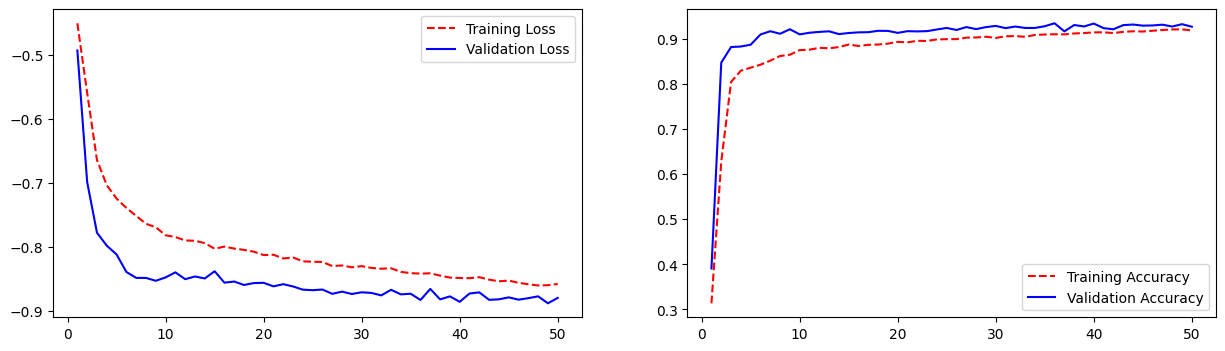

In [18]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

training_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

Below, we see some results from our work, presented as Predicted, Gold Standard (manually segmented) and the difference between segmentations.

In [19]:
test_gen = test_generator(test_files, target_size=(512, 512))
results = model.predict(test_gen, verbose=1)
save_result(SEGMENTATION_TEST_DIR, results, test_files)

100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Saving prediction: /content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0001_0_predict.png
Saving prediction: /content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0048_0_predict.png
Saving prediction: /content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0051_0_predict.png
Saving prediction: /content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0041_0_predict.png
Saving prediction: /content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0011_0_predict.png
Saving prediction: /content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0005_0_predict.png
Saving prediction: /content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0026_0_predict.png
Saving prediction: /content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0015_0_predict.png
Saving prediction: /content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0021_0_predict.png
Saving prediction: 

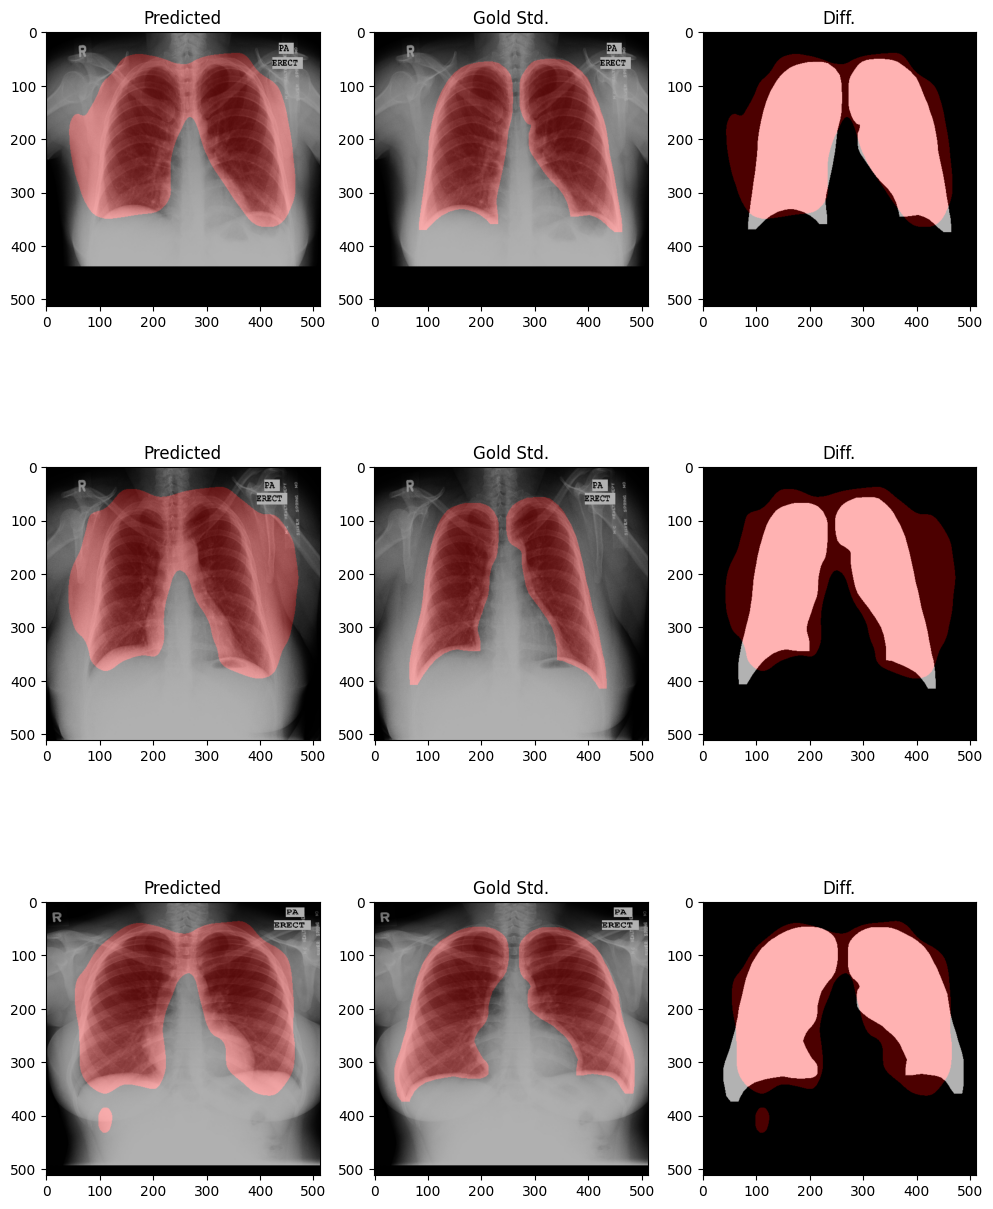

In [22]:
fig, axs = plt.subplots(3, 3, figsize=(12, 16))

image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0001_0.png")
predict_image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0001_0_predict.png")
mask_image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0001_0_dilate.png")
axs[0, 0].set_title("Predicted")
axs[0, 0].imshow(add_colored_mask(image, predict_image))
axs[0, 1].set_title("Gold Std.")
axs[0, 1].imshow(add_colored_mask(image, mask_image))
axs[0, 2].set_title("Diff.")
axs[0, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0002_0.png")
predict_image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0002_0_predict.png")
mask_image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0002_0_dilate.png")
axs[1, 0].set_title("Predicted")
axs[1, 0].imshow(add_colored_mask(image, predict_image))
axs[1, 1].set_title("Gold Std.")
axs[1, 1].imshow(add_colored_mask(image, mask_image))
axs[1, 2].set_title("Diff.")
axs[1, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0003_0.png")
predict_image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0003_0_predict.png")
mask_image = cv2.imread("/content/drive/MyDrive/Deep Learning/datasets/segmentation/test/MCUCXR_0003_0_dilate.png")
axs[2, 0].set_title("Predicted")
axs[2, 0].imshow(add_colored_mask(image, predict_image))
axs[2, 1].set_title("Gold Std.")
axs[2, 1].imshow(add_colored_mask(image, mask_image))
axs[2, 2].set_title("Diff.")
axs[2, 2].imshow(diff_mask(mask_image, predict_image))



# **Apply pretrained-model to RSNA dataset**

The next step will be the selection of lungs area on RSNA images dataset and the generation of a lungs-only image dataset.

In [23]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 52.2 MB/s eta 0:00:00


In [24]:
import os
import numpy as np
import pydicom
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from io import BytesIO
from PIL import Image
import zipfile as zf

import tensorflow as tf
from tensorflow.keras import layers, Model

In [ ]:
# from google.colab import files
# files.upload()  # Upload kaggle.json

# import os
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c rsna-pneumonia-detection-challenge

Saving kaggle.json to kaggle.json
100% 3.66G/3.66G [02:11<00:00, 27.6MB/s]
100% 3.66G/3.66G [02:11<00:00, 29.8MB/s]


In [26]:
base_rsna_dir = "/content/drive/MyDrive/Deep Learning/datasets/rsna_dataset"
train_X, train_Y = next(iter(train_gen))
mean, std = train_X.mean(), train_X.std()

def read_dicom_as_float(in_path):
    dicom = pydicom.dcmread(in_path)
    img = dicom.pixel_array.astype(np.float32)
    img = (img - np.mean(img)) / np.std(img)
    img = img * std + mean

    return np.expand_dims(img, axis=-1)  # Shape: (H, W, 1)

all_rsna_df = pd.DataFrame({'path': glob(os.path.join(base_rsna_dir, 'stage_*_images', '*.dcm'))})
sample_img = read_dicom_as_float(all_rsna_df.iloc[0, 0])
in_shape = sample_img.shape
in_shape

(1024, 1024, 1)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['DICOMInput']
Received: inputs=Tensor(shape=(1, 1024, 1024, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


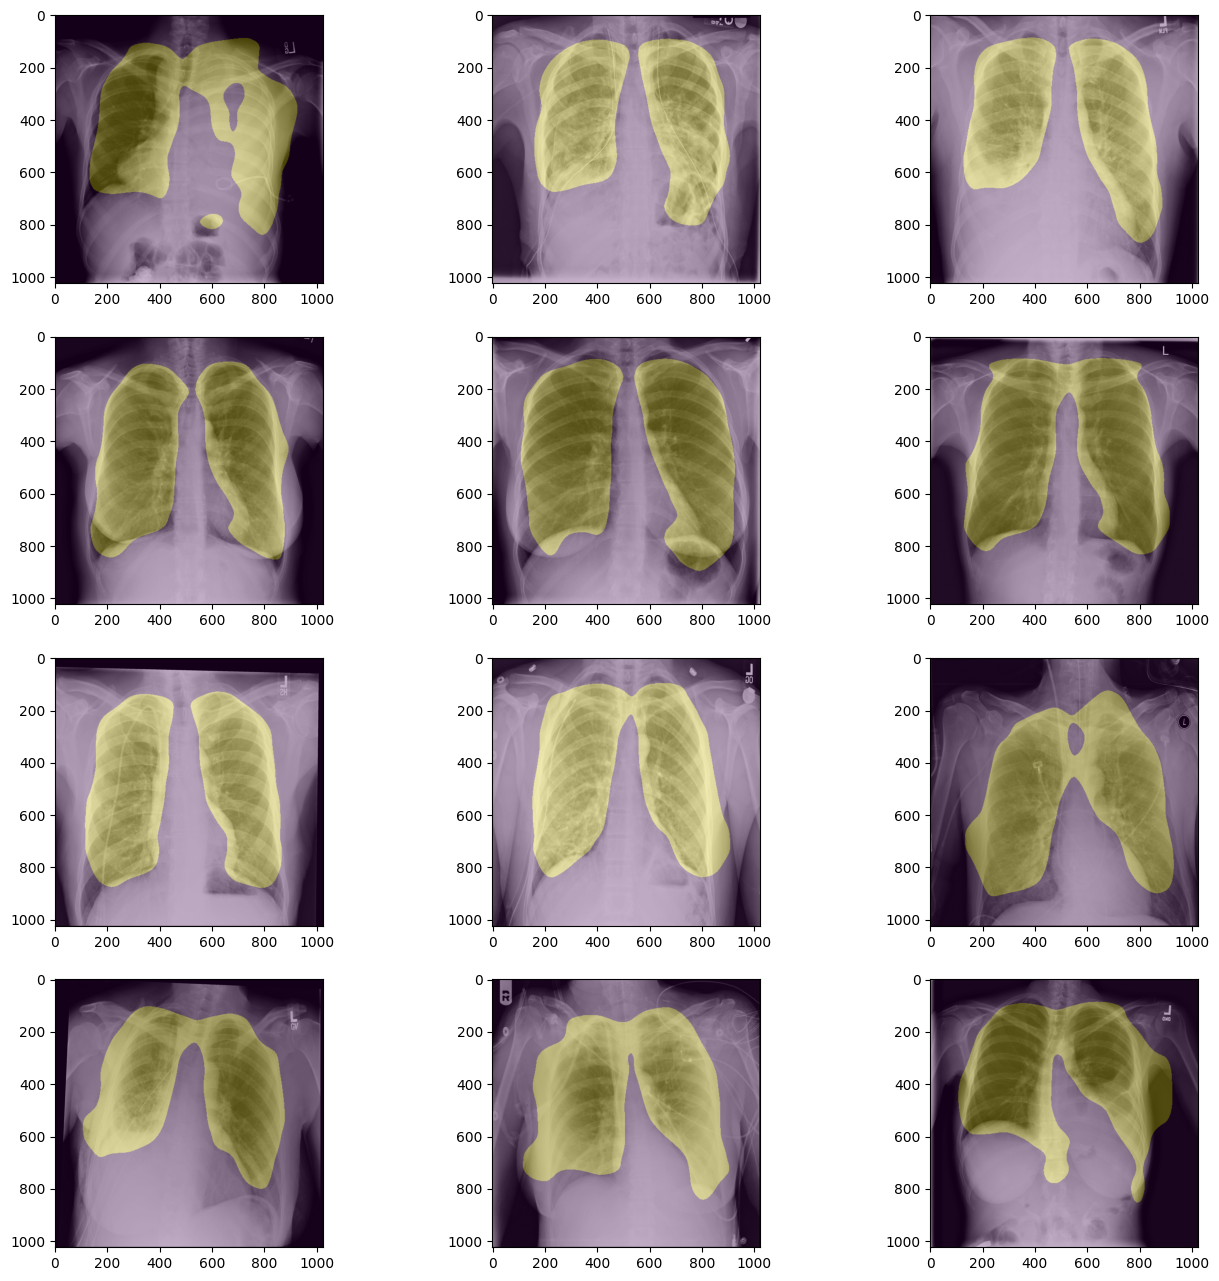

In [27]:
# Downsample using AvgPool2D
scale_factor = (2, 2)
in_img = layers.Input(in_shape, name='DICOMInput')
ds_dicom = layers.AvgPool2D(scale_factor)(in_img)
unet_out = model(ds_dicom)

us_out = layers.UpSampling2D(scale_factor)(unet_out)
unet_big = Model(inputs=[in_img], outputs=[us_out])
unet_big.save('deeplab_rsna_model.h5')

fig, axs = plt.subplots(4, 3, figsize=(16, 16))
for c_ax, (_, c_row) in zip(axs.flatten(), all_rsna_df[:12].iterrows()):
    img = read_dicom_as_float(c_row['path'])
    pred = unet_big.predict(np.expand_dims(img, axis=0))[0]
    c_ax.imshow(img[:, :, 0], cmap="gray")
    c_ax.imshow(pred[:, :, 0] > 0.5, alpha=0.3)  # Overlay prediction
plt.show()